In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn, einsum
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# SPT


In [2]:
import math 
class ShiftedPatchTokenization(nn.Module):
    def __init__(self, in_dim, dim, merging_size=2, exist_class_t=False, is_pe=False):
        super().__init__()
        
        self.exist_class_t = exist_class_t
        
        self.patch_shifting = PatchShifting(merging_size)
        
        patch_dim = (in_dim*5) * (merging_size**2) 
        if exist_class_t:
            self.class_linear = nn.Linear(in_dim, dim)

        self.is_pe = is_pe
        
        self.merging = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = merging_size, p2 = merging_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim)
        )

    def forward(self, x):
        
        if self.exist_class_t:
            visual_tokens, class_token = x[:, 1:], x[:, (0,)]
            reshaped = rearrange(visual_tokens, 'b (h w) d -> b d h w', h=int(math.sqrt(x.size(1))))
            out_visual = self.patch_shifting(reshaped)
            out_visual = self.merging(out_visual)
            out_class = self.class_linear(class_token)
            out = torch.cat([out_class, out_visual], dim=1)
        
        else:
            out = x if self.is_pe else rearrange(x, 'b (h w) d -> b d h w', h=int(math.sqrt(x.size(1))))
            out = self.patch_shifting(out)
            out = self.merging(out)    
        
        return out
        
class PatchShifting(nn.Module):
    def __init__(self, patch_size):
        super().__init__()
        self.shift = int(patch_size * (1/2))
        
    def forward(self, x):
     
        x_pad = torch.nn.functional.pad(x, (self.shift, self.shift, self.shift, self.shift))
        # if self.is_mean:
        #     x_pad = x_pad.mean(dim=1, keepdim = True)
        
        """ 4 cardinal directions """
        #############################
        # x_l2 = x_pad[:, :, self.shift:-self.shift, :-self.shift*2]
        # x_r2 = x_pad[:, :, self.shift:-self.shift, self.shift*2:]
        # x_t2 = x_pad[:, :, :-self.shift*2, self.shift:-self.shift]
        # x_b2 = x_pad[:, :, self.shift*2:, self.shift:-self.shift]
        # x_cat = torch.cat([x, x_l2, x_r2, x_t2, x_b2], dim=1) 
        #############################
        
        """ 4 diagonal directions """
        # #############################
        x_lu = x_pad[:, :, :-self.shift*2, :-self.shift*2]
        x_ru = x_pad[:, :, :-self.shift*2, self.shift*2:]
        x_lb = x_pad[:, :, self.shift*2:, :-self.shift*2]
        x_rb = x_pad[:, :, self.shift*2:, self.shift*2:]
        x_cat = torch.cat([x, x_lu, x_ru, x_lb, x_rb], dim=1) 
        # #############################
        
        """ 8 cardinal directions """
        #############################
        # x_l2 = x_pad[:, :, self.shift:-self.shift, :-self.shift*2]
        # x_r2 = x_pad[:, :, self.shift:-self.shift, self.shift*2:]
        # x_t2 = x_pad[:, :, :-self.shift*2, self.shift:-self.shift]
        # x_b2 = x_pad[:, :, self.shift*2:, self.shift:-self.shift]
        # x_lu = x_pad[:, :, :-self.shift*2, :-self.shift*2]
        # x_ru = x_pad[:, :, :-self.shift*2, self.shift*2:]
        # x_lb = x_pad[:, :, self.shift*2:, :-self.shift*2]
        # x_rb = x_pad[:, :, self.shift*2:, self.shift*2:]
        # x_cat = torch.cat([x, x_l2, x_r2, x_t2, x_b2, x_lu, x_ru, x_lb, x_rb], dim=1) 
        #############################
        
        # out = self.out(x_cat)
        out = x_cat
        
        return out

# PreNorm

In [3]:
class PreNorm(nn.Module):
    def __init__(self, num_tokens, dim, fn):
        super().__init__()
        self.dim = dim
        self.num_tokens = num_tokens
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), ** kwargs)

# Attention


In [4]:
def init_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

class Attention(nn.Module):
    def __init__(self, dim, num_patches, heads = 8, dim_head = 64, dropout = 0., is_LSA=False):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)
        self.num_patches = num_patches
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.dim = dim
        self.inner_dim = inner_dim
        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(self.dim, self.inner_dim * 3, bias = False)
        init_weights(self.to_qkv)
        self.to_out = nn.Sequential(
            nn.Linear(self.inner_dim, self.dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()
            
        if is_LSA:
            self.scale = nn.Parameter(self.scale*torch.ones(heads))    
            self.mask = torch.eye(self.num_patches+1, self.num_patches+1)
            self.mask = torch.nonzero((self.mask == 1), as_tuple=False)
        else:
            self.mask = None

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        if self.mask is None:
            dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        
        else:
            scale = self.scale
            dots = torch.mul(einsum('b h i d, b h j d -> b h i j', q, k), scale.unsqueeze(0).unsqueeze(-1).unsqueeze(-1).expand((b, h, 1, 1)))
            dots[:, :, self.mask[:, 0], self.mask[:, 1]] = -987654321

        attn = self.attend(dots)
        out = einsum('b h i j, b h j d -> b h i d', attn, v) 
            
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)
    
    def flops(self):
        flops = 0
        if not self.is_coord:
            flops += self.dim * self.inner_dim * 3 * (self.num_patches+1)
        else:
            flops += (self.dim+2) * self.inner_dim * 3 * self.num_patches  
            flops += self.dim * self.inner_dim * 3  

# FeedForward

In [5]:
class FeedForward(nn.Module):
    def __init__(self, dim, num_patches, hidden_dim, dropout = 0.):
        super().__init__()
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.num_patches = num_patches
        
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )            
    def forward(self, x):
        return self.net(x)

# DropPath (Regularizacion)

In [6]:
import torch
from torch.nn import Module

def drop_path(x, drop_prob: float = 0., training: bool = False):
    """
    Obtained from: github.com:rwightman/pytorch-image-models
    Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(Module):
    """
    Obtained from: github.com:rwightman/pytorch-image-models
    Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

# Transformer


In [7]:
class Transformer(nn.Module):
    def __init__(self, dim, num_patches, depth, heads, dim_head, mlp_dim_ratio, dropout = 0., stochastic_depth=0., is_LSA=False):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.scale = {}

        for i in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(num_patches, dim, Attention(dim, num_patches, heads = heads, dim_head = dim_head, dropout = dropout, is_LSA=is_LSA)),
                PreNorm(num_patches, dim, FeedForward(dim, num_patches, dim * mlp_dim_ratio, dropout = dropout))
            ]))            
        self.drop_path = DropPath(stochastic_depth) if stochastic_depth > 0 else nn.Identity()
    
    def forward(self, x):
        for i, (attn, ff) in enumerate(self.layers):       
            x = self.drop_path(attn(x)) + x
            x = self.drop_path(ff(x)) + x            
            self.scale[str(i)] = attn.fn.scale
        return x

# ViT


In [8]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class ViT(nn.Module):
    def __init__(self, *, img_size, patch_size, num_classes, dim, depth, heads, mlp_dim_ratio, channels = 3, 
                 dim_head = 16, dropout = 0., emb_dropout = 0., stochastic_depth=0.,is_LSA=False, is_SPT=False):
        super().__init__()
        image_height, image_width = pair(img_size)
        patch_height, patch_width = pair(patch_size)
        self.num_patches = (image_height // patch_height) * (image_width // patch_width)
        self.patch_dim = channels * patch_height * patch_width
        self.dim = dim
        self.num_classes = num_classes
       
        if not is_SPT:
            self.to_patch_embedding = nn.Sequential(
                Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
                nn.Linear(self.patch_dim, self.dim)
            )
            
        else:
            self.to_patch_embedding = ShiftedPatchTokenization(3, self.dim, patch_size, is_pe=True)
         
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, self.dim))
            
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.dim))
        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = Transformer(self.dim, self.num_patches, depth, heads, dim_head, mlp_dim_ratio, dropout, 
                                       stochastic_depth, is_LSA=is_LSA)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(self.dim),
            nn.Linear(self.dim, self.num_classes)
        )
        
        self.apply(init_weights)

    def forward(self, img):
        # patch embedding
        
        x = self.to_patch_embedding(img)
            
        b, n, _ = x.shape
        
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
      
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)      
        
        return self.mlp_head(x[:, 0])

# Preprocesado del dataset

Dataset cargado exitosamente.
Clases encontradas: 90
Número total de imágenes: 4320


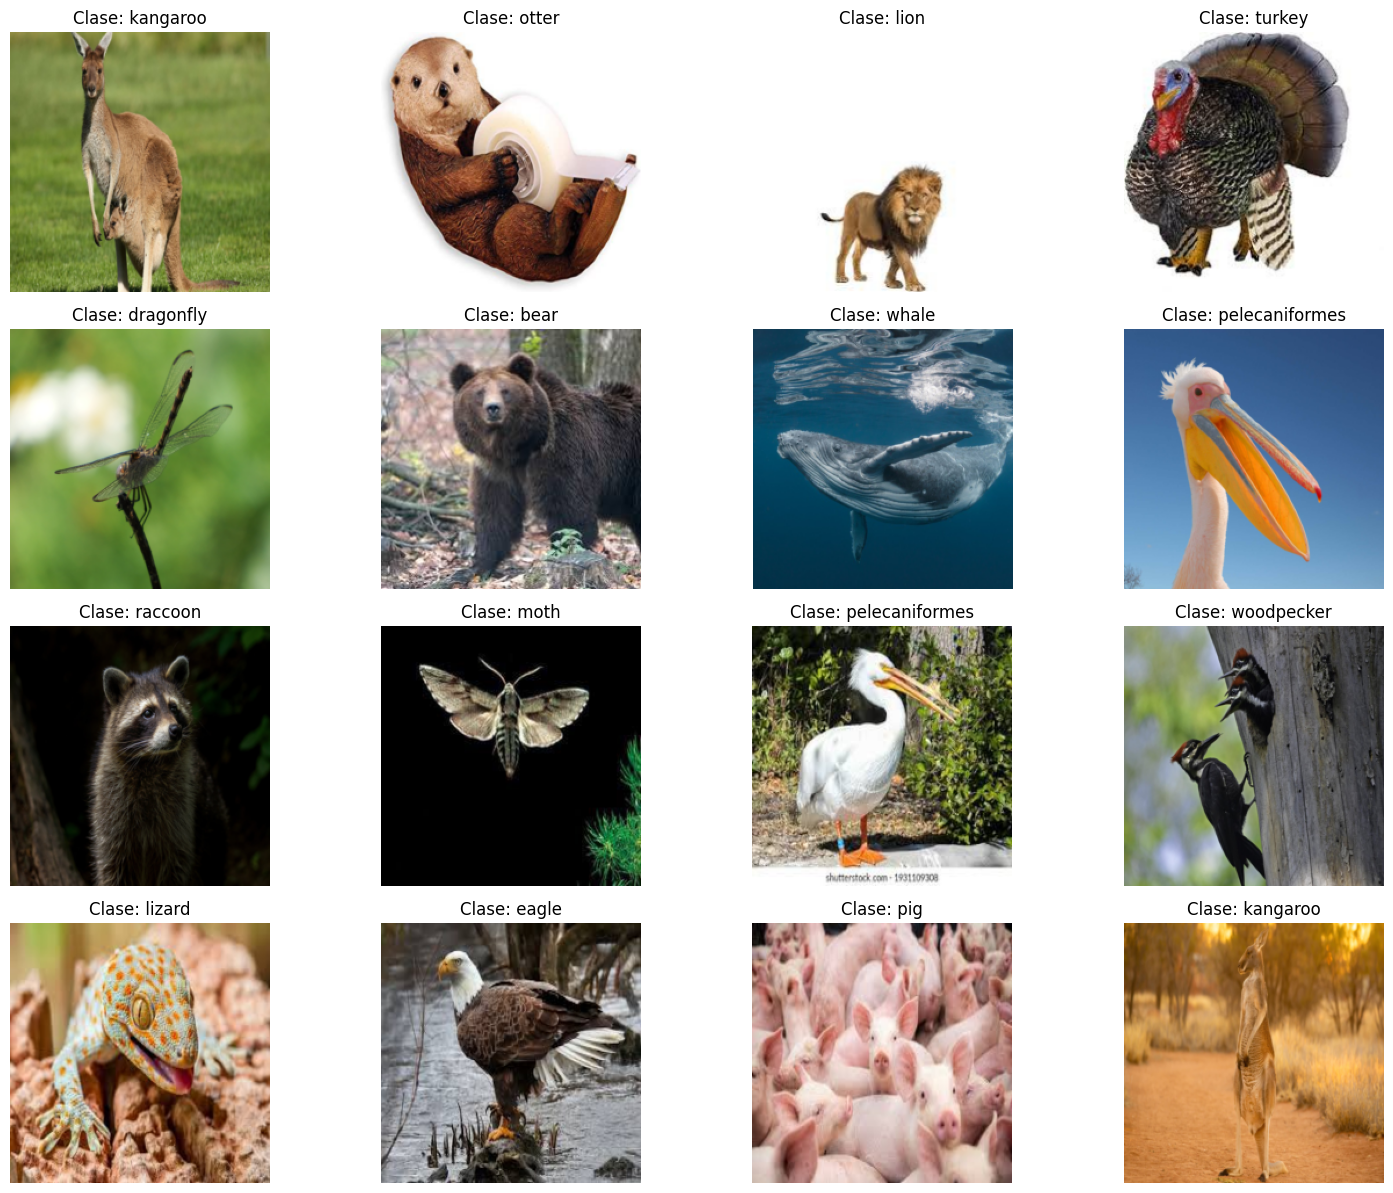

In [9]:
from torchvision import transforms, datasets
from torchvision.transforms.functional import to_pil_image
import random

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

DATA_PATH = 'dataset/'

# ImageFolder carga las imágenes y les asigna etiquetas según el nombre de la carpeta
train_data = datasets.ImageFolder(root=DATA_PATH + 'train/', transform=data_transforms)
print(f"Dataset cargado exitosamente.")
print(f"Clases encontradas: {len(train_data.classes)}")
print(f"Número total de imágenes: {len(train_data)}")

# 3. Función para mostrar imágenes (corregida y simplificada)
def show_images(dataset, num_samples=16, cols=4):
    """ Muestra una selección aleatoria de imágenes del dataset """
    if len(dataset) == 0:
        print("El dataset está vacío, no se pueden mostrar imágenes.")
        return

    plt.figure(figsize=(15, 15))
    # Selecciona índices aleatorios para mostrar una variedad de imágenes
    random_indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))

    for i, idx in enumerate(random_indices):
        # Obtenemos la imagen y su etiqueta del dataset
        image, label = dataset[idx]
        class_name = dataset.classes[label]

        # Creamos el subplot
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(to_pil_image(image))
        plt.title(f"Clase: {class_name}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 4. Llama a la función para visualizar las imágenes del dataset cargado
show_images(train_data)

# Inicialización del modelo

In [10]:
# --- Parámetros para el modelo ViT ---
img_size = 224  # Tamaño de la imagen de entrada (ej. 224x224)
patch_size = 16 # Tamaño de los parches (ej. 16x16)
num_classes = 90 # Número de clases para la clasificación (ej. ImageNet tiene 1000)
dim = 768 # Dimensión del embedding de los tokens (dimensión del modelo)
depth = 12 # Número de capas del Transformer
heads = 12 # Número de cabezas de atención
mlp_dim_ratio = 4 # Ratio para la dimensión oculta de la FFN (ej. 4 * dim)
channels = 3 # Número de canales de la imagen de entrada (3 para RGB)
dim_head = 64 # Dimensión de cada cabeza de atención (dim // heads)
dropout = 0.1 # Tasa de dropout general en el Transformer
emb_dropout = 0.1 # Tasa de dropout para el embedding posicional
stochastic_depth = 0.1 # Tasa de drop_path (Stochastic Depth)
is_LSA = False # Usar Localized Self-Attention (LSA)
is_SPT = False # Usar Shifted Patch Tokenization (SPT)

# --- Inicializar el modelo ViT ---
model = ViT(
    img_size = img_size,
    patch_size = patch_size,
    num_classes = num_classes,
    dim = dim,
    depth = depth,
    heads = heads,
    mlp_dim_ratio = mlp_dim_ratio,
    channels = channels,
    dim_head = dim_head,
    dropout = dropout,
    emb_dropout = emb_dropout,
    stochastic_depth = stochastic_depth,
    is_LSA = is_LSA,
    is_SPT = is_SPT
)

# --- Mover el modelo a la GPU si está disponible ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Modelo ViT creado y movido a: {device}")
print(f"Número de parámetros del modelo: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Modelo ViT creado y movido a: cpu
Número de parámetros del modelo: 85840218
